# Address parsing using Named Entity Recognition
Data & AI course, UC Leuven, 2021 Fall
### Project supervisors
- Tom Magerman
- Aimée Lynn Backiel

### Project team (Group 4)
- Karolis Medekša
- Pedro Teixeira Palma Rosa
- Hysa Mello de Alcântara
- Josep Jacob Chetrit Valdepeñas

## Goals
The goal of the assignment is to implement a solution for parsing individual parts of an address (street, house number, postal code, etc.) using a Natural Language Processing model. We can derive three subtasks from the assignment:
- converting training data into a format, accepted by the NLP library
- training a Named Entity Recognition pipeline and creating a NLP model with it
- Evaluating how accuratelly the model makes predictions

## NLP tool
As the final solution requires a python script, it was decided to use [spaCy](https://spacy.io/), as it is one of the most popular Natural Language Processing tools in python, it also features full support for Named Entity Recognition, which is required for solving the assignment.

## Preparing training data
The training data is presented in an excel file, where for each address there are columns with extracted values for different tokens:
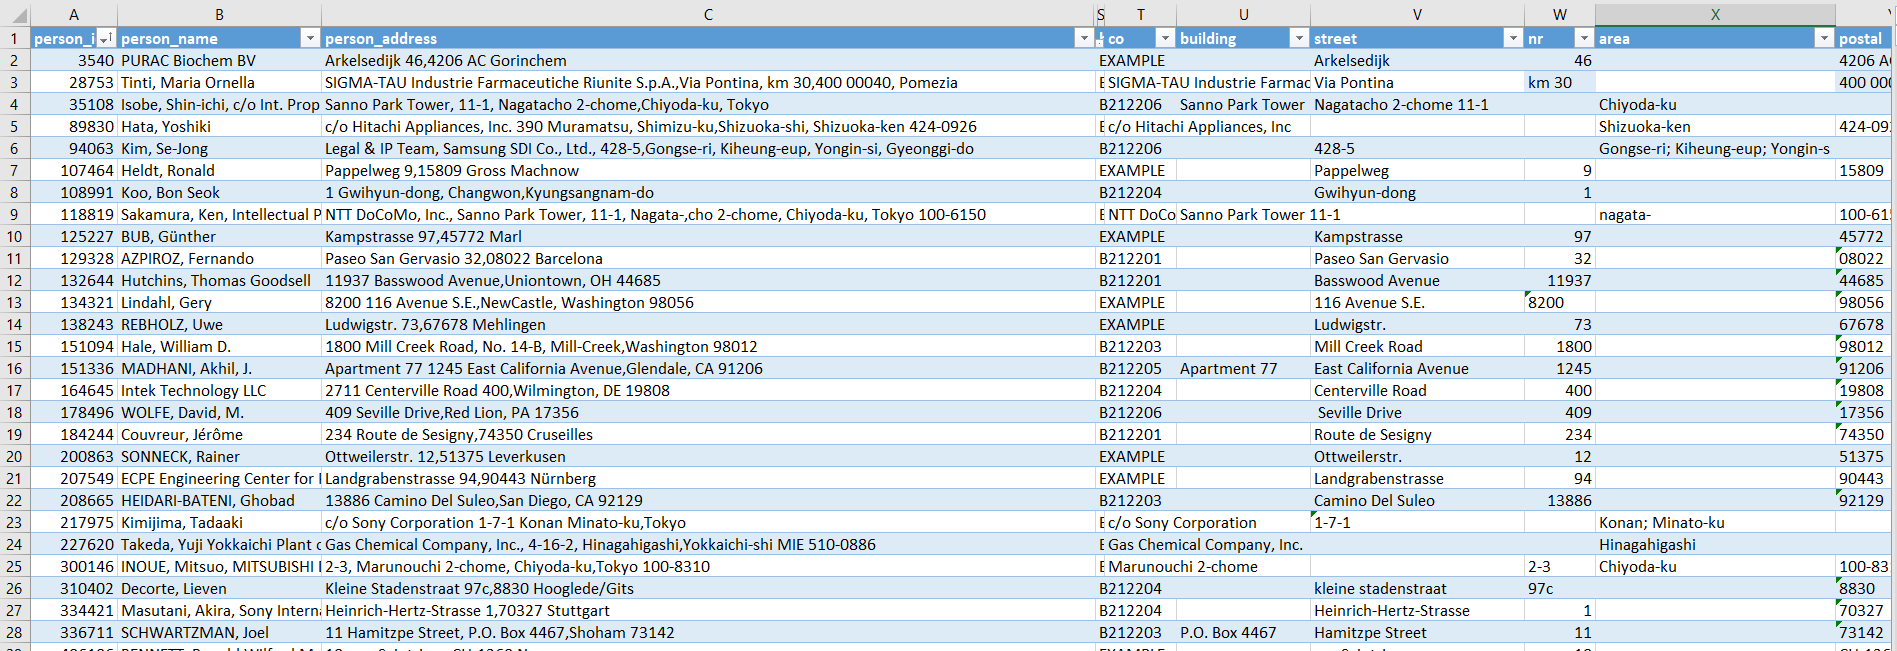

However, NER model training requires training data to be presented in a special format, by indicating positions in a string of different entities:
```python
# Example training data format
TRAIN_DATA = [
    ('Arkelsedijk 46,4206 AC Gorinchem', {
        'entities': [(0, 11, 'street'), (12, 14, 'nr'), (15, 22, 'postal'), (23, 32, 'city')]
    }), 
    ('SIGMA-TAU Industrie Farmaceutiche Riunite S.p.A.,Via Pontina, km 30,400 00040, Pomezia', {
        'entities': [(0, 48, 'co'), (49, 60, 'street'), (62, 67, 'nr'), (68, 77, 'postal'), (79, 86, 'city')]
    })
]
```

First we need code for reading raw training data into a `pandas` `DataFrame`

In [1]:
import pandas as pd

def read_DataFrame_from_file(filename: str, numberOfRows: int = None):
    return pd.read_excel(filename, nrows = numberOfRows, keep_default_na=False)

It is now possible to read the data and inspect it's format:

In [2]:
DATA_INPUT_FILENAME = 'training_data.xlsx'

raw_data: pd.DataFrame = read_DataFrame_from_file(DATA_INPUT_FILENAME, 10)
raw_data.head(3)

,person_id,person_name,person_address,cln1,cln2,cln3,person_ctry_code,cnt,chr_len,chr_len_label,...,street,nr,area,postal,city,region,country,unclear,status,label
0,3540,PURAC Biochem BV,"Arkelsedijk 46,4206 AC Gorinchem",Arkelsedijk 46 4206 AC Gorinchem,46 4206,46,NL,1,32,2,...,Arkelsedijk,46,,4206 AC,Gorinchem,,,,,1
1,28753,"Tinti, Maria Ornella",SIGMA-TAU Industrie Farmaceutiche Riunite S.p....,SIGMA-TAU Industrie Farmaceutiche Riunite S.p....,30 400 00040,30,IT,1,86,1,...,Via Pontina,km 30,,400 00040,Pomezia,,,,,1
2,35108,"Isobe, Shin-ichi, c/o Int. Prop. Dpt., NTT DoC...","Sanno Park Tower, 11-1, Nagatacho 2-chome,Chiy...",Sanno Park Tower 11-1 Nagatacho 2-chome Chiyod...,111 2,11-,JP,1,59,1,...,Nagatacho 2-chome 11-1,,Chiyoda-ku,,Tokyo,,,,,1


The following code can be used to transform the `DataFrame` into a format supported by `spaCy`:


First we transform the data frame into an array of of objects, where values are column values of each row using `DataFrame.to_dict('records')`. Function `map_to_training_entry` maps each object into a `tuple` of address and an object containing entity list. Finally, `get_entity_list` maps location of each entity in the address.

In [3]:
import re
import json

TOKEN_TYPES: set = {'co', 'building', 'street', 'nr', 'area', 'postal', 'city', 'region', 'country'}

def get_entity_list(entry: dict, address: str):
    entities: list = []
    present_tokens = filter(lambda item: item[0] in TOKEN_TYPES and item[1] and str(item[1]).strip(), entry.items())

    for item in present_tokens:
        token_value = str(item[1]).strip()
        match = re.search(re.escape(token_value), address)
        if match:
            span = match.span()
            entities.append((span[0], span[1], item[0]))
        else:
            # Try and resolve multiple tokens separated by ';'
            split_items = map(lambda token: token.strip(), token_value.split(';'))
            for token in split_items:
                split_match = re.search(re.escape(token), address)
                if split_match:
                    span = split_match.span()
                    entities.append((span[0], span[1], item[0]))
                else:
                    print('WARNING: could not find token "{}" in address "{}"'.format(token, address))
    
    return entities

def map_to_training_entry(entry: dict):
    address = entry['person_address']
    return (address, {
        'entities': get_entity_list(entry, address)
    })

train_data = list(
    map(map_to_training_entry, raw_data.to_dict('records'))
)

print("---- TRAINING DATA EXAMPLE ----")
print(train_data[0])

---- TRAINING DATA EXAMPLE ----
('Arkelsedijk 46,4206 AC Gorinchem', {'entities': [(0, 11, 'street'), (12, 14, 'nr'), (15, 22, 'postal'), (23, 32, 'city')]})


There are some entities for which there are warning about entities that were not found in the address string. We will discuss these problems later.

## Training the model
First we create a blank english `spaCy` model instance and add a `NER` pipeline into it. Address tokens also need to be added as labels to the pipeline.

In [4]:
import spacy 

nlp = spacy.blank('en')
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)

for token in TOKEN_TYPES:
    ner.add_label(token)

When training the model we use `minibatch` utility function to apply model updates in batches in order to increase performance. `compounding` utility is used to increase the batch size with further itearions. Usage of batching increases the training speed more than twice.

In [6]:
from spacy.util import minibatch, compounding
import random

optimizer = nlp.begin_training()
for itn in range(2):
    random.shuffle(train_data)
    losses = {}

    batches = minibatch(train_data, size=compounding(4, 32, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
            texts,  
            annotations,  
            drop=0.5,  
            sgd=optimizer,
            losses=losses)
    print('Iteration: {} | Losses: {}'.format(itn, losses))

Iteration: 0 | Losses: {'ner': 89.77388048171997}
Iteration: 1 | Losses: {'ner': 78.99851471185684}


The training works, however, we do get warnings that in some entities the tokens could not be used for training:
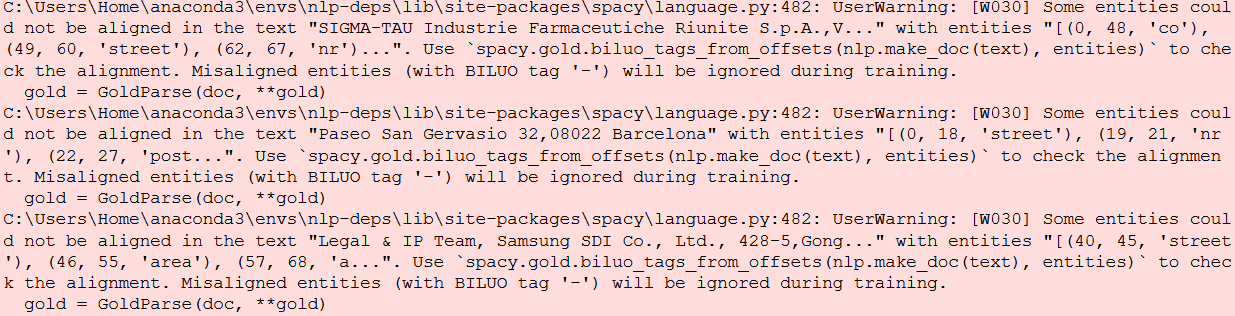

We will return to this issue in a later chapter. Also, if we try to train a model with all of the data, we run into an error:

In [7]:
%%capture

raw_data: pd.DataFrame = read_DataFrame_from_file(DATA_INPUT_FILENAME, 999)
train_data = list(
    map(map_to_training_entry, raw_data.to_dict('records'))
)

nlp = spacy.blank('en')
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)

for token in TOKEN_TYPES:
    ner.add_label(token)

optimizer = nlp.begin_training()
for itn in range(1):
    random.shuffle(train_data)
    losses = {}

    batches = minibatch(train_data, size=compounding(4, 32, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
            texts,  
            annotations,  
            drop=0.5,  
            sgd=optimizer,
            losses=losses)
    print('Iteration: {} | Losses: {}'.format(itn, losses))

ValueError: [E103] Trying to set conflicting doc.ents: '(0, 7, 'area')' and '(0, 7, 'city')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap.

### Conflicting entity errors
When the model is being trained with all the records, an error, indicating conflicting entities, is encountered. The issue will be addressed in a further chapter, for now, we can siply filter out entries having conflicting entities: 

In [9]:
def entities_overlap(entry):
    entities = entry[1]['entities']
    for first in entities:
        for second in entities:
            if (first == second): continue
            if (first[0] < second[0] and first[1] > second[0]) or (first[0] > second[0] and first[1] < second[0]) or (first[0]==second[0] or first[1]==second[1]):
                print('Entities {} and {} overlap in "{}"'.format(first, second, entry[0]))
                return True
    return False

train_data = list(filter(lambda entry: not entities_overlap(entry), train_data))

Entities (4, 74, 'co') and (4, 13, 'city') overlap in "5F, CHANGZHOU HIGH-TECH RESEARCH INSTITUTE OF NANJING UNIVERSITY CHANGZHOU, JIANGSU 213164 CHANGZHOU SCIENCE & EDUCATION TOWN, NO.801 MIDDLE CHANGWU ROAD"
Entities (23, 38, 'area') and (0, 38, 'area') overlap in "POLÍGONO INDUSTRIAL DE QUART DE POBLET, C/ LA PINAETA S/N, 46930 QUART DE POBLET VALENCIA ES"
Entities (0, 19, 'street') and (0, 2, 'nr') overlap in "14 Duntrune Terrace West Ferry,Dundee DD5 1LF Scotland"
Entities (0, 7, 'area') and (0, 7, 'city') overlap in "Enskede"
Entities (23, 31, 'postal') and (23, 25, 'region') overlap in "2 Sconsett Bluff,Avon, CT 06001"
Entities (48, 58, 'city') and (48, 54, 'region') overlap in "c/o Shinko El. Ind. Co.,Ltd. 80, Oshimada-machi,Nagano-shi Nagano 381-2287"
Entities (65, 74, 'area') and (65, 70, 'city') overlap in "c/o Taiki Corp., Ltd.,3-41 Nishiawaji 6-chome,Higashiyodogawa-ku,Osaka-shi Osaka 533-0031"
Entities (13, 33, 'area') and (13, 17, 'area') overlap in "4 NORMAN WAY,OVER IN

Now we can divide the present data into training and validation sets:

In [22]:
from sklearn.model_selection import train_test_split
import numpy as np

train_sample, test_sample = train_test_split(
    train_data, test_size = 0.2, random_state = 420
)
print('train entries: {} | test entries: {}'.format(len(train_sample), len(test_sample)))

train entries: 778 | test entries: 195


We can now train a model using the test data. For a baseline model we will perform 20 iterations of training:

In [24]:
nlp = spacy.blank('en')
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)

for token in TOKEN_TYPES:
    ner.add_label(token)

optimizer = nlp.begin_training()
for itn in range(20):
    random.shuffle(train_sample)
    losses = {}

    batches = minibatch(train_sample, size=compounding(4, 32, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
            texts,  
            annotations,  
            drop=0.5,  
            sgd=optimizer,
            losses=losses)
    print('Iteration: {} | Losses: {}'.format(itn, losses))

Iteration: 0 | Losses: {'ner': 3047.68327928675}
Iteration: 1 | Losses: {'ner': 2880.2026164971303}
Iteration: 2 | Losses: {'ner': 2624.2195279695447}
Iteration: 3 | Losses: {'ner': 2549.3434972041164}
Iteration: 4 | Losses: {'ner': 2410.465751566776}
Iteration: 5 | Losses: {'ner': 2342.9147328278573}
Iteration: 6 | Losses: {'ner': 2198.874550244972}
Iteration: 7 | Losses: {'ner': 2201.1767211930755}
Iteration: 8 | Losses: {'ner': 2118.442391669805}
Iteration: 9 | Losses: {'ner': 2084.389958909136}
Iteration: 10 | Losses: {'ner': 2029.0070619526118}
Iteration: 11 | Losses: {'ner': 1953.75416000656}
Iteration: 12 | Losses: {'ner': 1958.9142796220924}
Iteration: 13 | Losses: {'ner': 1834.4957377857934}
Iteration: 14 | Losses: {'ner': 1816.372640061109}
Iteration: 15 | Losses: {'ner': 1786.3032062708623}
Iteration: 16 | Losses: {'ner': 1683.3750419441453}
Iteration: 17 | Losses: {'ner': 1678.1313704151987}
Iteration: 18 | Losses: {'ner': 1612.5993487595124}
Iteration: 19 | Losses: {'ner':

## Evaluating model performance
We can evaluate how well the model performs by evaluating the accuracy, precision, recall and F1 score of train and test data.

In [53]:
## Maps the results object into a DataFrame
def results_per_entity_to_df(res: dict):
    columns = ['Token', 'Precision', 'Recall', 'F1 score']
    df = pd.DataFrame(columns=columns)
    total = pd.concat(
        [pd.DataFrame([['Total', res['ents_p'], res['ents_r'], res['ents_f']]], columns=columns)]
        , ignore_index=True
    )
    per_entity = pd.concat(
        [pd.DataFrame([
            [token, 
             res['ents_per_type'][token]['p'], 
             res['ents_per_type'][token]['r'], 
             res['ents_per_type'][token]['f']]
        ], columns=columns) for token in TOKEN_TYPES], ignore_index=True
    )
    return pd.concat([per_entity, total], ignore_index=True)

We can use `spaCy`'s own `scorer` utility to evaluate the performance for each different attribute. 

In [54]:
%%capture
from spacy.gold import GoldParse
from spacy.scorer import Scorer

def map_to_evaluation_model(entry: tuple):
    return (entry[0], entry[1]['entities'])


def evaluate(ner_model, examples):
    scorer = Scorer()
    for input_, annot in examples:
        doc_gold_text = ner_model.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot)
        pred_value = ner_model(input_)
        scorer.score(pred_value, gold)
    return scorer.scores

train_results = evaluate(nlp, map(map_to_evaluation_model, train_sample))
test_results = evaluate(nlp, map(map_to_evaluation_model, test_sample))

In [56]:
from IPython.display import display, HTML

## TODO: Add bar charts
print('---- Results on train data ----')
display(HTML(results_per_entity_to_df(train_results).to_html(index=False)))
print('---- Results on test data ----')
display(HTML(results_per_entity_to_df(test_results).to_html(index=False)))

---- Results on train data ----


Token,Precision,Recall,F1 score
area,74.226804,53.731343,62.337662
co,48.979592,57.142857,52.747253
region,85.546875,95.633188,90.309278
street,81.018519,91.145833,85.784314
city,86.823105,97.368421,91.793893
building,50.000000,5.405405,9.756098
country,100.000000,52.631579,68.965517
postal,92.178771,97.633136,94.827586
nr,92.000000,92.617450,92.307692
Total,84.884488,87.781570,86.308725


---- Results on test data ----


Token,Precision,Recall,F1 score
area,46.153846,27.906977,34.782609
co,44.444444,26.666667,33.333333
region,76.119403,82.258065,79.069767
street,50.746269,77.272727,61.261261
city,72.049689,85.925926,78.378378
building,0.000000,0.000000,0.000000
country,66.666667,50.000000,57.142857
postal,89.361702,87.500000,88.421053
nr,73.809524,72.093023,72.941176
Total,69.030733,73.182957,71.046229


We can see that although the model works pretty well for the house number, postal code, city, street and region with the training data. On the other hand, on test data the model does not perform very well. Performance on are, company and country tokens is exceptionally poor.


We can try to improve the performance of the model by fixing issues with training data presentation and parsing.

## Fixing data issues
### Incorrect data mappings in the training data
There were more than 120 instances in which a token could not be matched with the address string. Most of these are either spelling errors or extracted data positioned incorrectly:
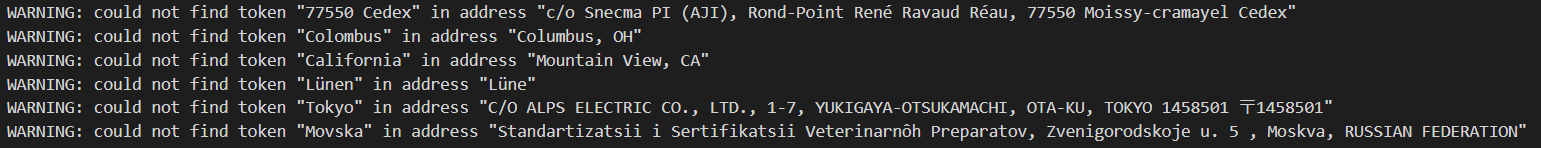


However, street names are almost always not matched for Japanese addresses, because they consist of two parts which are often not deparated by the semi-colon:
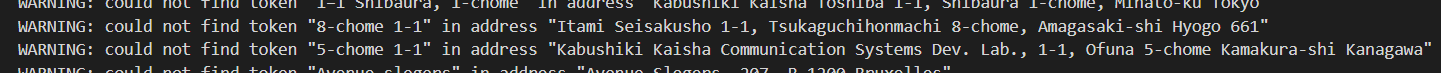


All of these issues were resolved in the training data file by hand.

### Fixing overlapping matches
There were multiple warning about overlapping entity mappings in the mapped data:
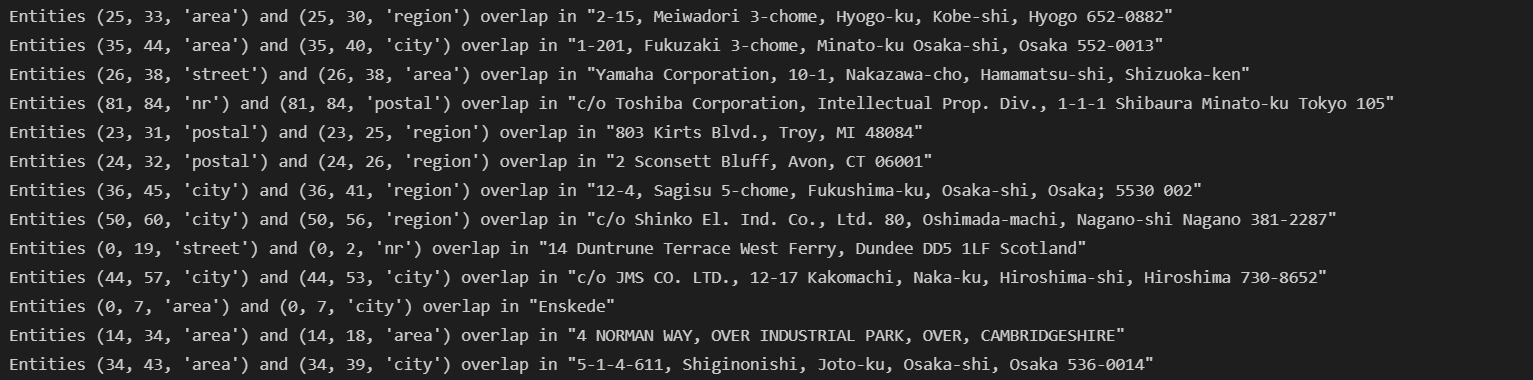

Some of the occurances are because of incorrect data, for instance, in `2 Sconsett Bluff, Avon, CT 06001` postal code is defined as `CT 06001` and the region is defined as `CT`, creating overlapping entries. These issues were resolved in the training data file by hand.


On the other hand, some of the issues were caused by a bug in the code. Current entity mapping solution just looks for a first match and uses it, but sometimes maps incorrectly. For instance, in address `2-15, Meiwadori 3-chome, Hyogo-ku, Kobe-shi, Hyogo 652-0882` te city name of `Hyogo` will be mapped as part of the area `Hyogo-ku` because it appears first.

Therefore, the entity mapping algorithm needs to be altered. It will now follow the pseudo-code:
```shell
FUNCTION get_entity_list (entries, address)
BEGIN
    entities = []
    retry = []
    FOR EACH entry IN entries
    DO
        IF entry IS MATCHED IN address SINGLE TIME
            ADD entry TO entities
            REPLACE entry WITH  "$" IN address
        ELSE
            ADD entry TO retry
    END
    
    FOR EACH entry IN retry
    DO
        IF entry IS MATCHED IN address
            ADD entry TO entities
            REPLACE entry WITH  "$" IN address 
    END
    
    RETURN entities
END
```

In [86]:
def get_entity_list(entry: dict, adr: str):
    address = str(adr)
    entities: list = []
    present_tokens = filter(lambda item: item[0] in TOKEN_TYPES and item[1] and str(item[1]).strip(), entry.items())

    ## tokens to retry matching
    retry_tokens: set = set()

    for item in present_tokens:
        token_value = str(item[1]).strip()
        match = re.search(re.escape(token_value), address)
        if match:
            # If multiple occurences can be matched, save the token to be matched later
            if (len(re.findall(re.escape(token_value), address)) > 1):
                retry_tokens.add((token_value, item[0]))
                continue
            span = match.span()
            entities.append((span[0], span[1], item[0]))
            # Replace matched entity with symbols, so that parts of it cannot be matched again
            address = address[:span[0]] + '$' * (span[1] - span[0]) + address[span[1]:]
        else:
            # Try and resolve multiple tokens separated by ';'
            split_items = map(lambda token: token.strip(), token_value.split(';'))
            for token in split_items:
                split_match = re.search(re.escape(token), address)
                if split_match:
                    # If multiple occurences can be matched, save the token to be matched later
                    if (len(re.findall(re.escape(token), address)) > 1):
                        retry_tokens.add((token, item[0]))
                        continue
                    span = split_match.span()
                    entities.append((span[0], span[1], item[0]))
                    # Replace matched entity with symbols, so that parts of it cannot be matched again
                    address = address[:span[0]] + '$' * (span[1] - span[0]) + address[span[1]:]
                else:
                    print('WARNING: could not find token "{}" in address "{}"'.format(token, adr))
    
    # Try and match previously marked tokens, now that single-match entities were eliminated
    for token, tkn_type in retry_tokens:
        token_value = str(token).strip()
        match = re.search(re.escape(token_value), address)
        if match:
            span = match.span()
            entities.append((span[0], span[1], tkn_type))
            address = address[:span[0]] + '$' * (span[1] - span[0]) + address[span[1]:]
        else:
            print('WARNING: could not find token "{}" in address "{}"'.format(token, adr))

    return entities

### Tokenization issues
While training the model there were warnings that some tokens could not be matched in addresses and will be ignored while training the model. It happens because the training process only supports entities that begin and end at token boundaries. 

Therefore, if postal code is defined as `04222` in string `LT04222` the instance will not be used for training because of a tokenization issue. These issues were fixed in the training data file by hand.

However, a significant amount of addresses have entities separated by commas without spaces, this causes a problem, because comma without any leading or trailing spaces is considered as a part of a token rather than a token separator. Because it applies to a large number of entities, we can use data pre-processing to add spaces after commas (and semi-colons) in these special cases:

In [87]:
def preprocess_data(data: pd.DataFrame):
    for col in data.columns:
        data[col] = data.apply(lambda row: re.sub(r'([^\s])([,;])([^\s])', r'\1\2 \3', str(row[col])), axis=1)

### Performance improvements 
Training the baseline model with improvements which should improve the applicability of the model:

In [88]:
raw_data: pd.DataFrame = read_DataFrame_from_file('label.xlsx', 999)
preprocess_data(raw_data)

train_data = list(
    map(map_to_training_entry, raw_data.to_dict('records'))
)
train_data = list(filter(lambda entry: not entities_overlap(entry), train_data))

train_sample, test_sample = train_test_split(
    train_data, test_size = 0.2, random_state = 420
)
print('train entries: {} | test entries: {}'.format(len(train_sample), len(test_sample)))

train entries: 799 | test entries: 200


In [89]:
nlp = spacy.blank('en')
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)

for token in TOKEN_TYPES:
    ner.add_label(token)

optimizer = nlp.begin_training()
for itn in range(20):
    random.shuffle(train_sample)
    losses = {}

    batches = minibatch(train_sample, size=compounding(4, 32, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
            texts,  
            annotations,  
            drop=0.5,  
            sgd=optimizer,
            losses=losses)
    print('Iteration: {} | Losses: {}'.format(itn, losses))

C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "28 Fayette Street, G-Unit, Cambrige MA 02139" with entities "[(3, 17, 'street'), (0, 2, 'nr'), (19, 25, 'area')...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "1621 Carlton Drive, Parsippany, NJ 07054" with entities "[(5, 18, 'street'), (0, 4, 'nr'), (36, 40, 'postal...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\language.py:

C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "1715 North Umberland Way, Monmouth Junction, New J..." with entities "[(5, 24, 'street'), (0, 4, 'nr'), (57, 61, 'postal...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "16 Skehan Street, Somerville, MA 02143" with entities "[(3, 16, 'street'), (0, 2, 'nr'), (34, 38, 'postal...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\langu

C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "Lehmikentäntie 236 C7, SF-90450 Kempele" with entities "[(0, 14, 'street'), (15, 21, 'nr'), (26, 31, 'post...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "Keilaranta 6, 02150 Espoo" with entities "[(0, 10, 'street'), (11, 12, 'nr'), (15, 19, 'post...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
C:\Users\Home\anaconda3\envs\nlp-deps\lib\site-packages\spacy\language.py:482: UserWarning: [W

Iteration: 0 | Losses: {'ner': 3935.3303609529835}
Iteration: 1 | Losses: {'ner': 3603.037494386306}
Iteration: 2 | Losses: {'ner': 3237.553698797605}
Iteration: 3 | Losses: {'ner': 2974.3943526687945}
Iteration: 4 | Losses: {'ner': 2909.796885772204}
Iteration: 5 | Losses: {'ner': 2774.363018541916}
Iteration: 6 | Losses: {'ner': 2688.5001025455967}
Iteration: 7 | Losses: {'ner': 2574.262160612052}
Iteration: 8 | Losses: {'ner': 2501.2932649144095}
Iteration: 9 | Losses: {'ner': 2407.419132637686}
Iteration: 10 | Losses: {'ner': 2315.039505015268}
Iteration: 11 | Losses: {'ner': 2275.454654695695}
Iteration: 12 | Losses: {'ner': 2136.9859981071722}
Iteration: 13 | Losses: {'ner': 2069.9802526935155}
Iteration: 14 | Losses: {'ner': 2073.158598033574}
Iteration: 15 | Losses: {'ner': 1922.2732200668884}
Iteration: 16 | Losses: {'ner': 2048.533670866713}
Iteration: 17 | Losses: {'ner': 1934.4999095729454}
Iteration: 18 | Losses: {'ner': 1838.3053221799682}
Iteration: 19 | Losses: {'ner': 

In [90]:
%%capture
train_results = evaluate(nlp, map(map_to_evaluation_model, train_sample))
test_results = evaluate(nlp, map(map_to_evaluation_model, test_sample))

In [91]:
print('---- Results on train data ----')
display(HTML(results_per_entity_to_df(train_results).to_html(index=False)))
print('---- Results on test data ----')
display(HTML(results_per_entity_to_df(test_results).to_html(index=False)))

---- Results on train data ----


Token,Precision,Recall,F1 score
area,78.773585,80.288462,79.523810
co,66.666667,67.391304,67.027027
region,93.333333,89.045936,91.139241
street,82.321900,88.636364,85.362517
city,93.362832,96.493902,94.902549
building,71.794872,41.791045,52.830189
country,82.142857,85.185185,83.636364
postal,97.058824,98.344371,97.697368
nr,86.567164,90.272374,88.380952
Total,88.253410,89.393939,88.820013


---- Results on test data ----


Token,Precision,Recall,F1 score
area,36.842105,41.176471,38.888889
co,41.176471,38.888889,40.000000
region,75.000000,76.056338,75.524476
street,62.745098,74.418605,68.085106
city,76.470588,77.380952,76.923077
building,0.000000,0.000000,0.000000
country,0.000000,0.000000,0.000000
postal,92.771084,93.902439,93.333333
nr,80.519481,86.111111,83.221477
Total,71.675302,74.239714,72.934974
